## 测一个分5层的+分三层的（第一版改进）

In [10]:
import pandas as pd

# Define the file paths for the datasets
ratings_file = './DIN/data/ml_1m/ratings.dat'
users_file = './DIN/data/ml_1m/users.dat'
movies_file = './DIN/data/ml_1m/movies.dat'

# Load the datasets
# The data in these files is separated by '::' and does not have a header row
ratings_df = pd.read_csv(ratings_file, sep='::', engine='python', encoding='latin1', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
users_df = pd.read_csv(users_file, sep='::', engine='python', encoding='latin1', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
movies_df = pd.read_csv(movies_file, sep='::', engine='python', encoding='latin1', header=None, names=['MovieID', 'Title', 'Genres'])

# Group by 'UserID' in ratings and count the number of movies each user has rated
user_movie_counts = ratings_df.groupby('UserID').size()

# Calculate the frequency of each movie count
frequency_counts = user_movie_counts.value_counts()

frequency_counts.head()  



21    91
20    86
23    81
24    81
22    77
dtype: int64

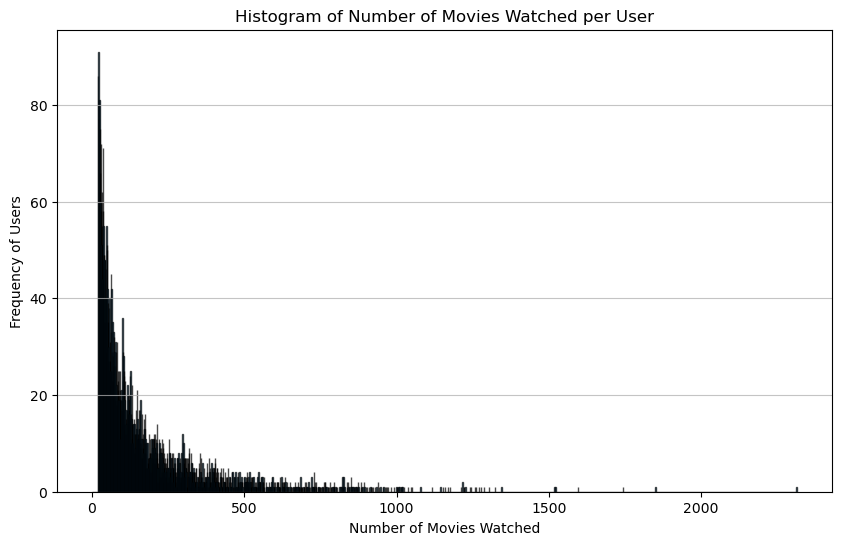

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(user_movie_counts, bins=range(1, user_movie_counts.max() + 1), edgecolor='black', alpha=0.7)
plt.title('Histogram of Number of Movies Watched per User')
plt.xlabel('Number of Movies Watched')
plt.ylabel('Frequency of Users')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [3]:
# Filter the user_movie_counts to find users who have watched 2000 or more movies
users_watched_2000_plus = user_movie_counts[user_movie_counts >= 2000]

# Display the UserIDs of these users
users_watched_2000_plus

UserID
4169    2314
dtype: int64

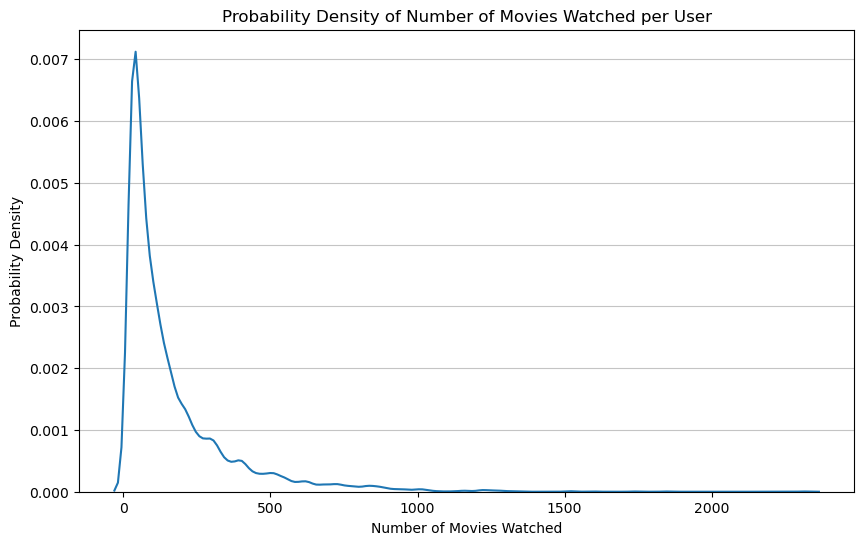

In [4]:
import seaborn as sns

# probability density curve

plt.figure(figsize=(10, 6))
sns.kdeplot(user_movie_counts, bw_adjust=0.5)
plt.title('Probability Density of Number of Movies Watched per User')
plt.xlabel('Number of Movies Watched')
plt.ylabel('Probability Density')
plt.grid(axis='y', alpha=0.75)

plt.show()


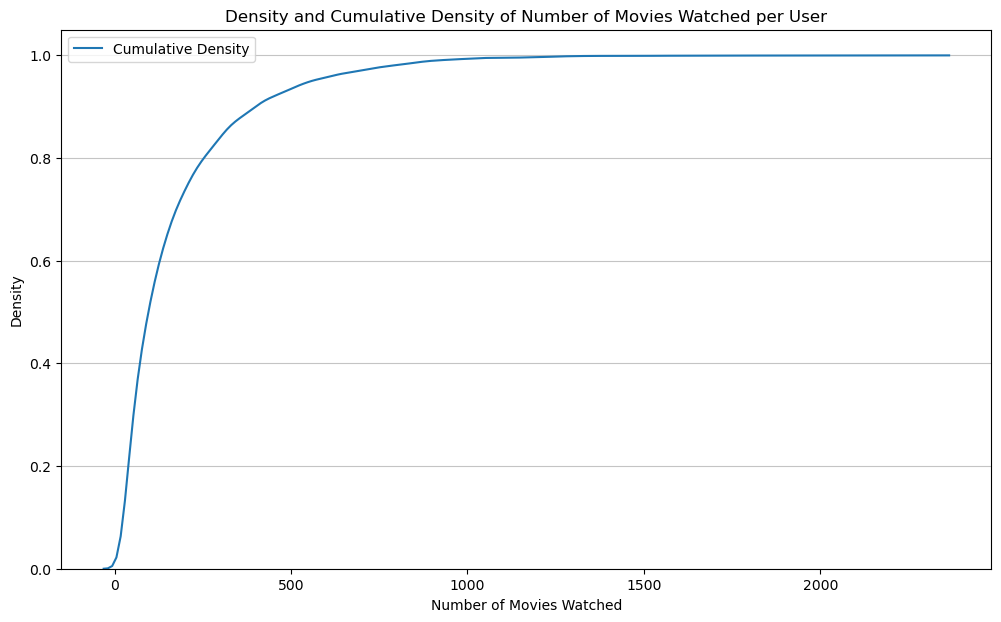

In [5]:
plt.figure(figsize=(12, 7))

# Cumulative Density Curve
sns.kdeplot(user_movie_counts, bw_adjust=0.5, cumulative=True, label='Cumulative Density')

plt.title('Density and Cumulative Density of Number of Movies Watched per User')
plt.xlabel('Number of Movies Watched')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', alpha=0.75)

plt.show()


In [6]:
# Define tagging function
def tag_user(watched_count):
    if watched_count < 60:
        return 0
    elif 60 <= watched_count < 160:
        return 1
    else:
        return 2

# Apply the tagging function
user_tags = user_movie_counts.apply(tag_user)

user_tags.head()  # Display the first few rows of the result

UserID
1    0
2    1
3    0
4    0
5    2
dtype: int64

In [7]:
# Convert user_tags to a DataFrame for merging
user_tags_df = user_tags.reset_index()
user_tags_df.columns = ['UserID', 'TagUser']  # Ensure correct column naming

# Merge the ratings DataFrame with the user tags DataFrame
ratings_with_tags = pd.merge(ratings_df, user_tags_df, on='UserID')

ratings_with_tags  # Display the merged DataFrame



,UserID,MovieID,Rating,Timestamp,TagUser
0,1,1193,5,978300760,0
1,1,661,3,978302109,0
2,1,914,3,978301968,0
3,1,3408,4,978300275,0
4,1,2355,5,978824291,0
...,...,...,...,...,...
1000204,6040,1091,1,956716541,2
1000205,6040,1094,5,956704887,2
1000206,6040,562,5,956704746,2
1000207,6040,1096,4,956715648,2


In [8]:
# Calculate the distribution of each tag in the data
tag_distribution = ratings_with_tags["TagUser"].value_counts()
tag_distribution  # Display the tag distribution

2    722381
1    201672
0     76156
Name: TagUser, dtype: int64

In [9]:
# Remove duplicate users from the dataset
unique_users_with_tags = ratings_with_tags.drop_duplicates(subset='UserID')

# Count the occurrences of each tag
tag_distribution = unique_users_with_tags['TagUser'].value_counts()
tag_distribution  # Display the tag distribution



0    2102
1    1982
2    1956
Name: TagUser, dtype: int64

把这个部分写成一个超参，等评分统
按User来分，服务对象为User

写一个网络——参数为e.g. 对User和item的分统：一键生成，写成class

特征：
1: activeType 以下所有内容更具用户所属群体划分计算
2: Average Unique Item number（分层）
3: Average Unique Item ratings - mean, Q3, Q1, std.（分层）
4: Average life span: 统计第一次和最后一次交互时间差（时间长短）平均life span [normalized time tag (or log)]
5: Average Unique Item number/Average life span = Average rate of watching.

添加特征
1: 个体life span留存时间长短
2: average item numbers in user time interval. (按160的rate来做)
3: normalized time tag (or log)

`Timestamp`: raw一串数字没有overlapping假设uni-continous


In [10]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
import numpy as np

# Calculating the features for each TagUser group

# 1. Average Unique Item Number
avg_unique_items = ratings_with_tags.groupby('TagUser')['MovieID'].nunique()

# 2. Average Unique Item Ratings
# Mean, Q1, Q3, and Standard Deviation of ratings for each group
ratings_stats = ratings_with_tags.groupby('TagUser')['Rating'].agg(['mean', 'std', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
ratings_stats.columns = ['Mean', 'Std', 'Q1', 'Q3']

# 3. Average Life Span
# Convert Timestamp to datetime
ratings_with_tags['Datetime'] = pd.to_datetime(ratings_with_tags['Timestamp'], unit='s')
life_span = ratings_with_tags.groupby(['UserID', 'TagUser']).agg({'Datetime': [np.min, np.max]})
life_span['Life_Span'] = (life_span['Datetime']['amax'] - life_span['Datetime']['amin']).dt.days
avg_life_span = life_span.groupby('TagUser')['Life_Span'].mean()

# 4. Average Rate of Watching
# Average Unique Item Number divided by Average Life Span
avg_rate_of_watching = avg_unique_items / avg_life_span

# Create a summary dataframe for the calculated features
summary_df = pd.DataFrame({
    'Average Unique Item Number': avg_unique_items,
    'Average Rating Mean': ratings_stats['Mean'],
    'Average Rating Std': ratings_stats['Std'],
    'Average Rating Q1': ratings_stats['Q1'],
    'Average Rating Q3': ratings_stats['Q3'],
    'Average Life Span': avg_life_span,
    'Average Rate of Watching': avg_rate_of_watching
})

summary_df.reset_index()


,TagUser,Average Unique Item Number,Average Rating Mean,Average Rating Std,Average Rating Q1,Average Rating Q3,Average Life Span,Average Rate of Watching
0,0,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371
1,1,3358,3.749103,1.090479,3.0,5.0,65.962664,50.907586
2,2,3665,3.515218,1.117249,3.0,4.0,204.243354,17.944280


In [12]:
# Merging the summary information back to the original ratings dataframe

# First, prepare the summary information for merging
summary_for_merge = summary_df.reset_index()

# Renaming columns for clarity when merging
rename_dict = {
    'Average Unique Item Number': 'Tag_Avg_Unique_Items',
    'Average Rating Mean': 'Tag_Avg_Rating_Mean',
    'Average Rating Std': 'Tag_Avg_Rating_Std',
    'Average Rating Q1': 'Tag_Avg_Rating_Q1',
    'Average Rating Q3': 'Tag_Avg_Rating_Q3',
    'Average Life Span': 'Tag_Avg_Life_Span',
    'Average Rate of Watching': 'Tag_Avg_Rate_Watching'
}
summary_for_merge.rename(columns=rename_dict, inplace=True)

# Merging
ratings_df2 = ratings_with_tags.merge(summary_for_merge, how='left', left_on='TagUser', right_on='TagUser')

# Displaying the first few rows to verify the merge
ratings_df2.head()


,UserID,MovieID,Rating,Timestamp,TagUser,Datetime,Tag_Avg_Unique_Items,Tag_Avg_Rating_Mean,Tag_Avg_Rating_Std,Tag_Avg_Rating_Q1,Tag_Avg_Rating_Q3,Tag_Avg_Life_Span,Tag_Avg_Rate_Watching
0,1,1193,5,978300760,0,2000-12-31 22:12:40,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371
1,1,661,3,978302109,0,2000-12-31 22:35:09,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371
2,1,914,3,978301968,0,2000-12-31 22:32:48,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371
3,1,3408,4,978300275,0,2000-12-31 22:04:35,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371
4,1,2355,5,978824291,0,2001-01-06 23:38:11,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371


In [13]:
# Calculating individual user features

# 1. Individual Life Span (Latest Time Tag - First Time Tag)
individual_life_span = ratings_df2.groupby('UserID')['Datetime'].agg([np.min, np.max])
individual_life_span['Individual_Life_Span'] = (individual_life_span['amax'] - individual_life_span['amin']).dt.days

# 2. Average Item Numbers in User Time Interval
# Counting total movies watched by each user and dividing by their life span
individual_movie_counts = ratings_df2.groupby('UserID')['MovieID'].count()
individual_avg_item_numbers = individual_movie_counts / individual_life_span['Individual_Life_Span']

# 3. Normalized Time Tag (Log)
# Applying log transformation to the timestamp for normalization
ratings_df2['Normalized_Time_Tag'] = np.log(ratings_df2['Timestamp'])

# Merge the individual features back into the ratings_with_tags DataFrame
individual_features = individual_life_span[['Individual_Life_Span']].merge(individual_avg_item_numbers.rename('Avg_Items_per_Day'), left_index=True, right_index=True)
ratings_df3 = ratings_df2.merge(individual_features, how='left', left_on='UserID', right_index=True)

# Displaying the first few rows to verify the merge
ratings_df3.head()

,UserID,MovieID,Rating,Timestamp,TagUser,Datetime,Tag_Avg_Unique_Items,Tag_Avg_Rating_Mean,Tag_Avg_Rating_Std,Tag_Avg_Rating_Q1,Tag_Avg_Rating_Q3,Tag_Avg_Life_Span,Tag_Avg_Rate_Watching,Normalized_Time_Tag,Individual_Life_Span,Avg_Items_per_Day
0,1,1193,5,978300760,0,2000-12-31 22:12:40,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371,20.701328,6,8.833333
1,1,661,3,978302109,0,2000-12-31 22:35:09,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371,20.701329,6,8.833333
2,1,914,3,978301968,0,2000-12-31 22:32:48,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371,20.701329,6,8.833333
3,1,3408,4,978300275,0,2000-12-31 22:04:35,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371,20.701327,6,8.833333
4,1,2355,5,978824291,0,2001-01-06 23:38:11,3156,3.767228,1.117992,3.0,5.0,20.106089,156.967371,20.701863,6,8.833333


===========

In [14]:
# Count the number of ratings for each movie
movie_rating_counts = ratings_df.groupby('MovieID').size()

# Calculate the frequency of each rating count
frequency_counts = movie_rating_counts.value_counts()

# Display the results
print(frequency_counts)


1       114
2        89
4        45
3        42
5        39
       ... 
593       1
2583      1
997       1
2278      1
437       1
Length: 924, dtype: int64


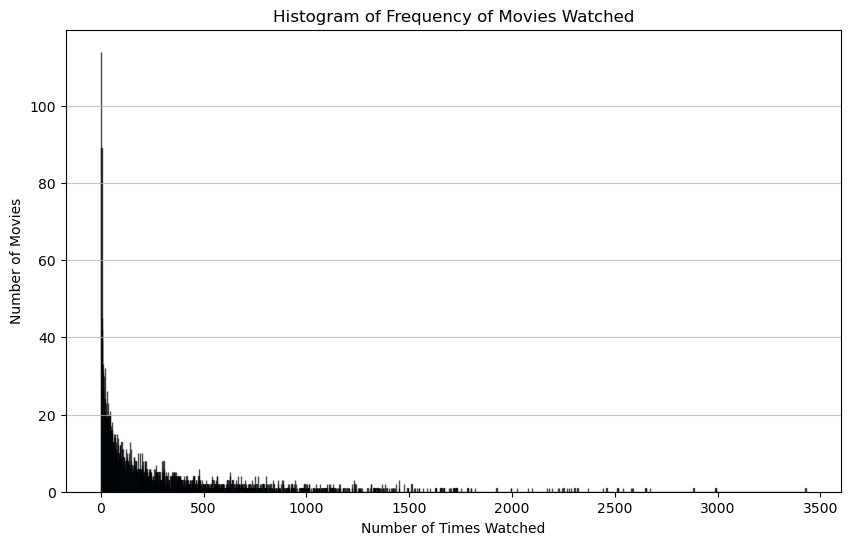

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_counts, bins=range(1, max(movie_rating_counts) + 2), edgecolor='black', alpha=0.7)
plt.title('Histogram of Frequency of Movies Watched')
plt.xlabel('Number of Times Watched')
plt.ylabel('Number of Movies')
plt.grid(axis='y', alpha=0.75)

plt.show()

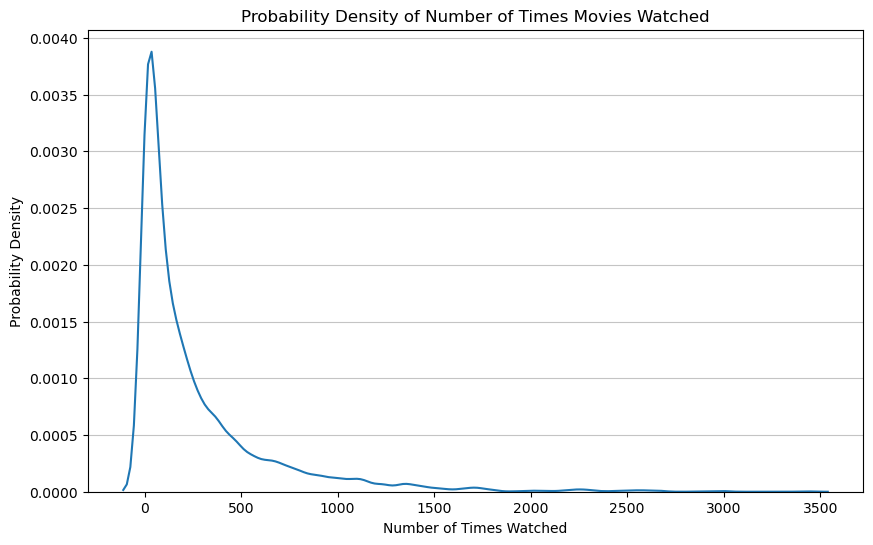

In [16]:
plt.figure(figsize=(10, 6))

sns.kdeplot(movie_rating_counts, bw_adjust=0.5)
plt.title('Probability Density of Number of Times Movies Watched')
plt.xlabel('Number of Times Watched')
plt.ylabel('Probability Density')
plt.grid(axis='y', alpha=0.75)

plt.show()

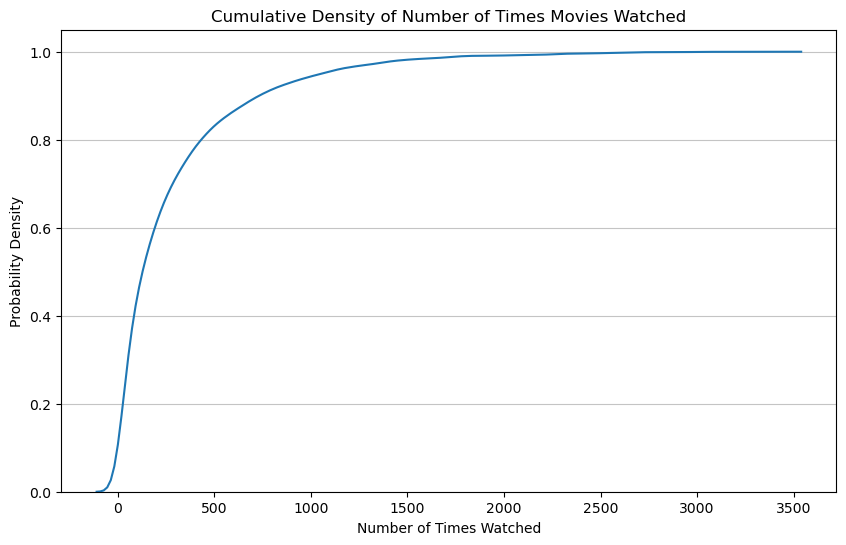

In [17]:
plt.figure(figsize=(10, 6))

sns.kdeplot(movie_rating_counts, bw_adjust=0.5, cumulative=True, label='Cumulative Density')
plt.title('Cumulative Density of Number of Times Movies Watched')
plt.xlabel('Number of Times Watched')
plt.ylabel('Probability Density')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [18]:
# Define tagging function
def tag_movie(watch_count):
    if watch_count < 55:
        return 0
    elif 55 <= watch_count < 250:
        return 1
    else:
        return 2

# Apply the tagging function to each movie
movie_tags = movie_rating_counts.apply(tag_movie)
movie_tags.head()  # Display the first few rows of the result


MovieID
1    2
2    2
3    2
4    1
5    2
dtype: int64

In [19]:
# Convert movie_tags to a DataFrame for merging
movie_tags_df = movie_tags.reset_index()
movie_tags_df.columns = ['MovieID', 'TagMovie']  # Ensure correct column naming

# Merge the ratings DataFrame with the movie tags DataFrame
ratings_with_tags = pd.merge(ratings_with_tags, movie_tags_df, on='MovieID')

ratings_with_tags  # Display the merged DataFrame

,UserID,MovieID,Rating,Timestamp,TagUser,Datetime,TagMovie
0,1,1193,5,978300760,0,2000-12-31 22:12:40,2
1,2,1193,5,978298413,1,2000-12-31 21:33:33,2
2,12,1193,4,978220179,0,2000-12-30 23:49:39,2
3,15,1193,4,978199279,2,2000-12-30 18:01:19,2
4,17,1193,5,978158471,2,2000-12-30 06:41:11,2
...,...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,2,2000-05-20 18:13:21,0
1000205,5675,2703,3,976029116,2,2000-12-05 15:11:56,0
1000206,5780,2845,1,958153068,2,2000-05-12 17:37:48,0
1000207,5851,3607,5,957756608,2,2000-05-08 03:30:08,0


In [20]:
# Calculate the distribution of each tag in the data
tag_distribution = ratings_with_tags["TagMovie"].value_counts()
tag_distribution  # Display the tag distribution

2    808922
1    165068
0     26219
Name: TagMovie, dtype: int64

In [21]:
# Remove duplicate users from the dataset
unique_movies_with_tags = ratings_with_tags.drop_duplicates(subset='MovieID')

# Count the occurrences of each tag
tag_distribution = unique_movies_with_tags['TagMovie'].value_counts()
tag_distribution  # Display the tag distribution

0    1266
1    1224
2    1216
Name: TagMovie, dtype: int64

1. 每一个item对应的不同activetype用户数量（比例）[:3]要做归一化
2. 每一个item对应的不同activetype用户评分 Q1/Q2/Q3/std
3. rating by unique movie & group by 'TagMovie', Q1/Q2/Q3/std


In [22]:
# Now let's perform the analysis as requested

# 1. Count of different TagUser for each movie (normalized)
taguser_count_per_movie = ratings_with_tags.groupby(['MovieID', 'TagUser']).size().unstack(fill_value=0)
# Normalizing
taguser_count_normalized = taguser_count_per_movie.divide(taguser_count_per_movie.sum(axis=1), axis=0)

# 2. Different TagUser's ratings statistics (Q1/Q2/Q3/std) for each movie
taguser_ratings_stats_per_movie = ratings_with_tags.groupby(['MovieID', 'TagUser'])['Rating'].agg(['mean', 'std', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)]).unstack()
taguser_ratings_stats_per_movie.columns = ['TagUser_0_Mean', 'TagUser_1_Mean', 'TagUser_2_Mean', 'TagUser_0_Std', 'TagUser_1_Std', 'TagUser_2_Std', 'TagUser_0_Q1', 'TagUser_1_Q1', 'TagUser_2_Q1', 'TagUser_0_Q2', 'TagUser_1_Q2', 'TagUser_2_Q2', 'TagUser_0_Q3', 'TagUser_1_Q3', 'TagUser_2_Q3']
# 3. Ratings by unique movie & group by 'TagMovie', with statistics (Q1/Q2/Q3/std)
tagmovie_ratings_stats = ratings_with_tags.groupby(['TagMovie', 'MovieID'])['Rating'].agg(['mean', 'std', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75)])
tagmovie_ratings_stats.columns = ['Mean', 'Std', 'Q1','Q2', 'Q3']
# Display the first few rows of each calculated DataFrame for verification
(taguser_count_normalized.head(), taguser_ratings_stats_per_movie.head(), tagmovie_ratings_stats.head())


(TagUser         0         1         2
 MovieID                              
 1        0.118922  0.293693  0.587386
 2        0.045649  0.176890  0.777461
 3        0.094142  0.158996  0.746862
 4        0.041176  0.088235  0.870588
 5        0.060811  0.108108  0.831081,
          TagUser_0_Mean  TagUser_1_Mean  TagUser_2_Mean  TagUser_0_Std  \
 MovieID                                                                  
 1              4.089069        4.203279        4.130328       0.928414   
 2              3.312500        3.411290        3.146789       1.090649   
 3              3.155556        3.197368        2.960784       1.106911   
 4              3.142857        2.266667        2.756757       0.690066   
 5              2.888889        3.125000        3.000000       1.323493   
 
          TagUser_1_Std  TagUser_2_Std  TagUser_0_Q1  TagUser_1_Q1  \
 MovieID                                                             
 1             0.813266       0.854596          4.00       

In [23]:
taguser_ratings_stats_per_movie.head()
#tagmovie_ratings_stats.head()

,TagUser_0_Mean,TagUser_1_Mean,TagUser_2_Mean,TagUser_0_Std,TagUser_1_Std,TagUser_2_Std,TagUser_0_Q1,TagUser_1_Q1,TagUser_2_Q1,TagUser_0_Q2,TagUser_1_Q2,TagUser_2_Q2,TagUser_0_Q3,TagUser_1_Q3,TagUser_2_Q3
MovieID,,,,,,,,,,,,,,,
1,4.089069,4.203279,4.130328,0.928414,0.813266,0.854596,4.00,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0
2,3.312500,3.411290,3.146789,1.090649,0.954341,0.977934,2.75,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0
3,3.155556,3.197368,2.960784,1.106911,1.083448,1.061919,3.00,3.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0
4,3.142857,2.266667,2.756757,0.690066,1.222799,0.994007,3.00,1.0,2.0,3.0,2.0,3.0,3.5,3.0,3.0
5,2.888889,3.125000,3.000000,1.323493,1.099853,0.993859,2.00,3.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0


In [24]:
# It seems that the variable 'taguser_ratings_stats_per_movie_flat' was not defined. Let's define it and perform the merge.

# Merging taguser_ratings_stats_per_movie
ratings_df4 = ratings_df3.merge(taguser_ratings_stats_per_movie, on='MovieID', how='left')

# Displaying the first few rows of the updated dataframe for verification
ratings_df4.head()

# Merging taguser_ratings_stats_per_movie
ratings_df5 = ratings_df4.merge(tagmovie_ratings_stats, on='MovieID', how='left')

# Displaying the first few rows of the updated dataframe for verification
ratings_df5.head()


,UserID,MovieID,Rating,Timestamp,TagUser,Datetime,Tag_Avg_Unique_Items,Tag_Avg_Rating_Mean,Tag_Avg_Rating_Std,Tag_Avg_Rating_Q1,...,TagUser_1_Q2,TagUser_2_Q2,TagUser_0_Q3,TagUser_1_Q3,TagUser_2_Q3,Mean,Std,Q1,Q2,Q3
0,1,1193,5,978300760,0,2000-12-31 22:12:40,3156,3.767228,1.117992,3.0,...,5.0,5.0,5.0,5.0,5.0,4.390725,0.789524,4.0,5.0,5.0
1,1,661,3,978302109,0,2000-12-31 22:35:09,3156,3.767228,1.117992,3.0,...,4.0,4.0,4.0,4.0,4.0,3.464762,1.023202,3.0,4.0,4.0
2,1,914,3,978301968,0,2000-12-31 22:32:48,3156,3.767228,1.117992,3.0,...,4.0,4.0,5.0,5.0,5.0,4.154088,0.873854,4.0,4.0,5.0
3,1,3408,4,978300275,0,2000-12-31 22:04:35,3156,3.767228,1.117992,3.0,...,4.0,4.0,5.0,5.0,4.0,3.863878,0.895887,3.0,4.0,4.0
4,1,2355,5,978824291,0,2001-01-06 23:38:11,3156,3.767228,1.117992,3.0,...,4.0,4.0,5.0,4.0,4.0,3.854375,0.879284,3.0,4.0,4.0


In [25]:
first_row = ratings_df5.iloc[0]
first_row

UserID                                     1
MovieID                                 1193
Rating                                     5
Timestamp                          978300760
TagUser                                    0
Datetime                 2000-12-31 22:12:40
Tag_Avg_Unique_Items                    3156
Tag_Avg_Rating_Mean                 3.767228
Tag_Avg_Rating_Std                  1.117992
Tag_Avg_Rating_Q1                        3.0
Tag_Avg_Rating_Q3                        5.0
Tag_Avg_Life_Span                  20.106089
Tag_Avg_Rate_Watching             156.967371
Normalized_Time_Tag                20.701328
Individual_Life_Span                       6
Avg_Items_per_Day                   8.833333
TagUser_0_Mean                      4.335277
TagUser_1_Mean                      4.385106
TagUser_2_Mean                      4.414474
TagUser_0_Std                       0.865929
TagUser_1_Std                       0.798847
TagUser_2_Std                       0.753571
TagUser_0_

In [26]:
# iterating the columns
for col in ratings_df5.columns:
    print(col)

UserID
MovieID
Rating
Timestamp
TagUser
Datetime
Tag_Avg_Unique_Items
Tag_Avg_Rating_Mean
Tag_Avg_Rating_Std
Tag_Avg_Rating_Q1
Tag_Avg_Rating_Q3
Tag_Avg_Life_Span
Tag_Avg_Rate_Watching
Normalized_Time_Tag
Individual_Life_Span
Avg_Items_per_Day
TagUser_0_Mean
TagUser_1_Mean
TagUser_2_Mean
TagUser_0_Std
TagUser_1_Std
TagUser_2_Std
TagUser_0_Q1
TagUser_1_Q1
TagUser_2_Q1
TagUser_0_Q2
TagUser_1_Q2
TagUser_2_Q2
TagUser_0_Q3
TagUser_1_Q3
TagUser_2_Q3
Mean
Std
Q1
Q2
Q3


后文：
使用mask干预attention等等...

过DL拼到BERT的输出层上（维度在1/2）

### The following is the DIN part

In [13]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')
